In [9]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pandas as pd

# Monte Carlo (MC) simulation
Let $y = \beta_1 x_1 + \epsilon$ be **the true model**. 

We will simulate data from this model and then use OLS to estimate two versions of the model: 
 * $y = \beta_{1_{mc}}x_1 + \epsilon$ 
 * $y =   \beta_{1_{mc}}x_1 +  \beta_{2_{mc}}x_2 + \epsilon$

Using three different sample sizes, we analyze the effect of sample size on the estimated value for $\beta_1$.


Just define some input parameters for the MC simulation

In [11]:
# Set the parameters in the model
b1 = 5
b2 = -2

# The std of the error term
sigma = np.sqrt(2)

# We will play with three different sample sizes and see how this affects the results 
N = [100, 500, 1000]
# The number of simulations
S = 1000

Simulate the covariates as multivariate normal distributed

In [12]:
# Generate the x values as draws from the multivariate normal distributions
cov   = [[0.7, 0.4],
         [0.4, 0.3]]
mu = [0, 0]
# Simple way of drawing random numbers from the multivariate normal distribution        
x1, x2 = np.random.multivariate_normal(mu, cov, max(N)).T

## Monte Carlo Simulation

In [13]:
# define some lists to save the results that we need
all_beta1=[]
all_beta1_m2=[]
all_beta1_m1=[]
all_type=[]
all_model=[]
# loop through the N sample sizes and for each draw S y's and 
# find the OSL estimate for beta 1
for n in N:
  for s in range(S):
    eps = np.random.normal(0,sigma,n)
    # simulate the process
    y = b1*x1[:n] + eps

    # extimate b1 under model 1 and model 2 
    y = y[:,None]
    x = x1[:n][:,None]
    beta_mc1 = np.dot(np.linalg.inv(np.dot(x.T,x)),np.dot(x.T,y))[0][0]
    x = np.c_[x1[:n], x2[:n]]
    beta_mc2 = np.dot(np.linalg.inv(np.dot(x.T,x)),np.dot(x.T,y))[0][0]

    # save estimates, and sample size, in a list. Then, we create a df
    all_beta1.append(beta_mc1)
    if n == 100:
      all_type.append('small')
      all_beta1_m1.append(beta_mc1)
      all_beta1_m2.append(beta_mc2)
    elif n == 500:
      all_type.append('medium')
    elif n == 1000:
      all_type.append('large')

# save results in dataframe. Such format simplifies plotting densities with sns   
df = pd.DataFrame(data={'beta m1 estimate': all_beta1, 'sample size':all_type})
sample_size = np.r_[np.tile('m1_small',S),
                    np.tile('m2_small',S)
                   ]
df2 = pd.DataFrame(data={'beta estimate': np.r_[all_beta1_m1,all_beta1_m2],\
                         'sample size':sample_size})

# Histograms, quantiles and asymtotic confidence intervals

In [14]:
# fit an OLS to get standard errors (bse) and calculate 
# the asymptotic confidence intervals for beta1
x = x1[:n][:,None]
ols_model = sm.OLS(y,x).fit()
asym_95 = [b1-2*ols_model.bse[0], b1+2*ols_model.bse[0]]
#simply use the quantiles for the monte carlo estimate
quantile_95 = np.quantile(all_beta1[S:],[0.025,0.975])

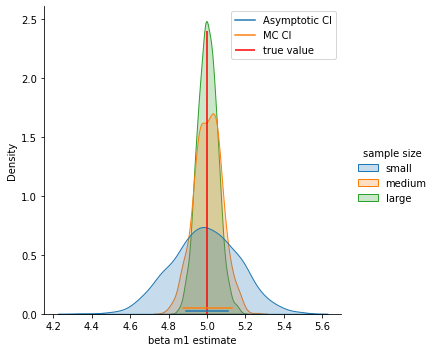

In [15]:
# plot the estimate for beta under the 3 different sample sizes
# sns.displot handles it automatically using the "hue" argument
sns.displot(df,x='beta m1 estimate',hue="sample size",kind='kde',fill=True)
plt.vlines(x=b1,ymin=0,ymax=2.4,colors='r',label='true value')
plt.plot(asym_95,[0.02,0.02],label='Asymptotic CI')
plt.plot(quantile_95,[0.05,0.05],label='MC CI')
plt.legend()
plt.savefig('uncertainty.pdf')
plt.show()

Unbiased $\beta_1$ estimates in all three cases, but the larger the sample size is, the **less uncertainity**. 

# $\beta$ parameter under the two models

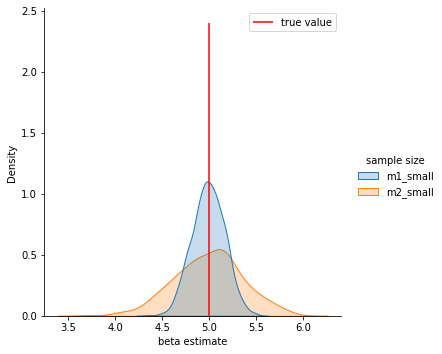

In [16]:
sns.displot(df2,x='beta estimate',hue="sample size",kind='kde',fill=True)
plt.vlines(x=b1,ymin=0,ymax=2.4,colors='r',label='true value')
plt.legend()
plt.savefig('uncertainty2.pdf')
plt.show()


Unbiased $\beta_1$ estimates in both cases, but using the correct model produces less uncertain results, i.e. including variables that are not really true results in uncertain estimates. 

# Wrong model especification
Now, let $y = \beta_1 x_1 + \beta_2 x_2 + \epsilon$ be the true model. 

Simulate data from this model and then use OLS to estimate two versions of the model: 
 * $y = \beta_{1_{mc}}x_1 + \epsilon$ 
 
Again, use three different sample sizes and  analyze its effect on the estimated value for $\beta_1$.

In [17]:
# define some lists to save the results that we need
all_beta1=[]
all_type=[]
# loop through the N sample sizes and for each draw S y's and 
# find the OSL estimate for beta 1
for n in N:
  for s in range(S):
    eps = np.random.normal(0,sigma,n)
    # simulate the process
    y = b1*x1[:n] + b2*x2[:n] + eps

    # extimate b1 under model 1 and model 2 
    y = y[:,None]
    x = x1[:n][:,None]
    beta_mc1 = np.dot(np.linalg.inv(np.dot(x.T,x)),np.dot(x.T,y))[0][0]
    
    # save estimates, and sample size, in a list. Then, we create a df
    all_beta1.append(beta_mc1)
    
    if n == 100:
      all_type.append('small')
    elif n == 500:
      all_type.append('medium')
    elif n == 1000:
      all_type.append('large')

# save results in dataframe. Such format simplifies plotting densities with sns   
df3 = pd.DataFrame(data={'beta m1 estimate': all_beta1, 'sample size':all_type})

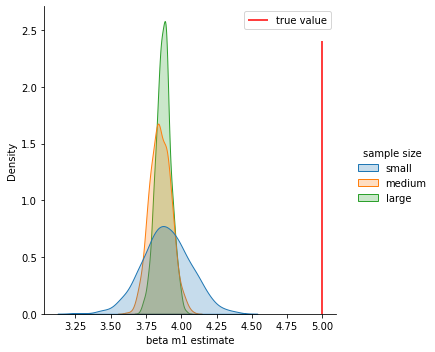

In [18]:
sns.displot(df3,x='beta m1 estimate',hue="sample size",kind='kde',fill=True)
plt.vlines(x=b1,ymin=0,ymax=2.4,colors='r',label='true value')
plt.legend()
plt.savefig('uncertainty3.pdf')
plt.show()

**Biased** $\beta_1$ regardless of the sample size!